In [1]:
from sympy import false, true
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pickle
import matplotlib.pyplot as plt
import optuna
import json

/opt/anaconda3/envs/ep_forecasting_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)

In [3]:
torch.set_num_threads(torch.get_num_threads())  # Nutzt standardmäßig alle verfügbaren Kerne
print(f"PyTorch nutzt {torch.get_num_threads()} Threads")


PyTorch nutzt 8 Threads


In [4]:
# In Torch-Tensoren umwandeln
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Datasets und DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last = True, num_workers = 8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last = True, num_workers = 8)

In [5]:
X_train.shape[0]

27024

In [6]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hp):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hp['rnn_units'], batch_first=True)
        self.dropout1 = nn.Dropout(hp['dropout_rate_rnn'])
        self.fc1 = nn.Linear(hp['rnn_units'], hp['dense_units'])
        self.dropout2 = nn.Dropout(hp['dropout_rate_dense'])
        self.fc2 = nn.Linear(hp['dense_units'], 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Nur der letzte Zeitschritt
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        return out

In [ ]:
def objective(trial):
    hp = {
        'rnn_units': trial.suggest_int('rnn_units', 16, 128, step=16),
        'dropout_rate_rnn': trial.suggest_float('dropout_rate_rnn', 0.1, 0.5, step=0.1),
        'dense_units': trial.suggest_int('dense_units', 8, 64, step=8),
        'dropout_rate_dense': trial.suggest_float('dropout_rate_dense', 0.0, 0.4, step=0.1),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4]),
        'weight_decay': trial.suggest_categorical('weight_decay', [1e-5, 1e-4, 1e-3]),
    }

    rnn_model = SimpleRNN(input_size = X_train.shape[2], hp= hp)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=hp['learning_rate'], weight_decay=hp['weight_decay'])

    num_epochs = 15
    patience = 7  # Stop, wenn val_loss sich 10 Epochen lang nicht verbessert
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        rnn_model.train()
        train_loss = 0.0

        # Training Loop
        for X_batch, y_batch in train_loader:
            y_pred = rnn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation Loop (nach jeder Epoche)
        rnn_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = rnn_model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0  # Reset Counter
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping nach {epoch+1} Epochen.")
                break

    return best_val_loss  # Val Loss zurückgeben für Optuna

# Hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, n_jobs = 8)

# Show Best Result
print("Best trial parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")


[I 2025-03-31 12:51:48,366] A new study created in memory with name: no-name-48d7f4e7-1f3d-4e65-bef0-4f6e46c9807d


Epoch [1/15], Train Loss: 0.0056, Val Loss: 0.0028
Epoch [2/15], Train Loss: 0.0026, Val Loss: 0.0031
Epoch [3/15], Train Loss: 0.0028, Val Loss: 0.0026
Epoch [4/15], Train Loss: 0.0029, Val Loss: 0.0018
Epoch [1/15], Train Loss: 0.0080, Val Loss: 0.0019
Epoch [1/15], Train Loss: 0.0221, Val Loss: 0.0066
Epoch [1/15], Train Loss: 0.0210, Val Loss: 0.0045
Epoch [1/15], Train Loss: 0.0029, Val Loss: 0.0019
Epoch [1/15], Train Loss: 0.0119, Val Loss: 0.0018
Epoch [5/15], Train Loss: 0.0029, Val Loss: 0.0016
Epoch [1/15], Train Loss: 0.0034, Val Loss: 0.0011
Epoch [1/15], Train Loss: 0.0044, Val Loss: 0.0017
Epoch [6/15], Train Loss: 0.0030, Val Loss: 0.0028
Epoch [7/15], Train Loss: 0.0030, Val Loss: 0.0026
Epoch [8/15], Train Loss: 0.0030, Val Loss: 0.0021


In [16]:
# save best hyperparameters
best_hp = study.best_trial.params
with open("best_hp_all_models/best_hp_rnn.json", "w") as f:
    json.dump(best_hp, f)

NameError: name 'study' is not defined

In [ ]:
# load best hyperparameters 
with open("best_hp_all_models/best_hp_rnn.json", "r") as f:
    best_hp = json.load(f)


Epoch [1/50], Train Loss: 0.0052, Val Loss: 0.0010
Epoch [2/50], Train Loss: 0.0021, Val Loss: 0.0011
Epoch [3/50], Train Loss: 0.0015, Val Loss: 0.0008
Epoch [4/50], Train Loss: 0.0013, Val Loss: 0.0006
Epoch [5/50], Train Loss: 0.0012, Val Loss: 0.0007
Epoch [6/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [7/50], Train Loss: 0.0010, Val Loss: 0.0008
Epoch [8/50], Train Loss: 0.0010, Val Loss: 0.0009
Epoch [9/50], Train Loss: 0.0010, Val Loss: 0.0007
Epoch [10/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [11/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [12/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [13/50], Train Loss: 0.0009, Val Loss: 0.0008
Epoch [14/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [15/50], Train Loss: 0.0009, Val Loss: 0.0007
Epoch [16/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [17/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [18/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [19/50], Train Loss: 0.0009, Val Loss: 0.0007
Epoch [20/50], Train 

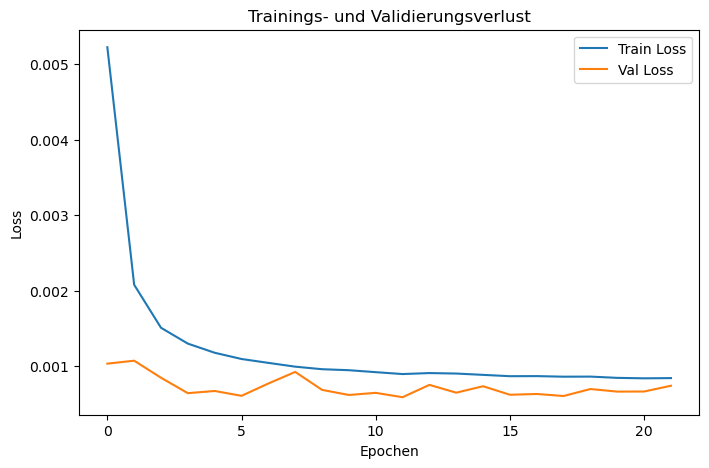

In [ ]:
# Bestes Modell mit den gefundenen Hyperparametern trainieren
best_hp = study.best_trial.params
final_model = SimpleRNN(input_size=X_train.shape[2], hp=best_hp)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_hp['learning_rate'], weight_decay=best_hp['weight_decay'])

num_epochs = 50
train_loss_history = []
val_loss_history = []
patience = 10
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    final_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = final_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # Validation Loss berechnen
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = final_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset Counter
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping nach {epoch+1} Epochen.")
            break

    # Save weights of the model 
    torch.save(final_model.state_dict(), "saved_models/rnn_model_final.pth")

# **Trainingshistorie plotten**
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.title("Trainings- und Validierungsverlust")
plt.show()

In [13]:
# load trained model  
rnn_final = SimpleRNN(input_size=X_train.shape[2], hp=best_hp)
rnn_final.load_state_dict(torch.load("saved_models/rnn_model_final.pth"))
rnn_final.eval()

SimpleRNN(
  (rnn): RNN(17, 112, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

rnn_final.eval()
test_loss = 0
test_predictions = []
test_targets = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch
        y_test_batch = y_test_batch

        test_outputs = model(X_test_batch).squeeze()
        loss = criterion(test_outputs, y_test_batch.squeeze())
        test_loss += loss.item()

        test_predictions.extend(test_outputs.cpu().numpy())
        test_targets.extend(y_test_batch.squeeze().cpu().numpy())

# Mittelwert des Kriteriums (z. B. MSELoss)
test_loss /= len(test_loader)
print(f"Test Loss (MSE): {test_loss:.4f}")

# RMSE
def RMSELoss(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

# Torch-Tensors
y_pred_tensor = torch.tensor(test_predictions)
y_true_tensor = torch.tensor(test_targets)

rmse = RMSELoss(y_pred_tensor, y_true_tensor).item()
print(f"Test RMSE (PyTorch): {rmse:.4f}")

NameError: name 'model' is not defined